References:

https://www.kaggle.com/kswamy15/mercari-using-pytorch

http://scikit-learn.org/stable/modules/ensemble.html

In [1]:
import torch
from torch.autograd import Variable
from torch import optim
from torch.optim import lr_scheduler
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd
from time import time

In [62]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import density
from sklearn import metrics
import math
%matplotlib inline

In [4]:
train_df = pd.read_csv('data/mercari/train.tsv', sep='\t')
test_df = pd.read_csv('data/mercari/test.tsv', sep='\t')

In [5]:
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [6]:
train_df.shape

(1482535, 8)

In [7]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [8]:
print('Train columns with null values:\n', train_df.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', test_df.isnull().sum())
print("-"*10)

train_df.describe(include = 'all')

Train columns with null values:
 train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64
----------
Test/Validation columns with null values:
 test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64
----------


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482531
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281426
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


Calculate how much of the brand names are not there.

In [9]:
print(632682/train_df.shape[0])

0.4267568725190299


Around 50% is not there hence we should probably not consider this.

In [10]:
train_df = train_df.drop(['brand_name'], axis=1)
test_df = test_df.drop(['brand_name'], axis=1)

# categories

We need to check how many categories there are

In [11]:
# Merge the two dataframes
frames = [train_df, test_df]
combined_df = pd.concat(frames)

In [12]:
combined_cat_df = combined_df['category_name']
def split_cat(text):
    try: return text.split("/")
    except: pass

combined_cat_df = combined_cat_df.apply(lambda x: split_cat(x))

In [13]:
def no_of_cats(cat_list):
    try: return len(cat_list)
    except: return 0
    
no_of_cats = pd.DataFrame(combined_cat_df.apply(lambda x: no_of_cats(x)))

In [14]:
# no_of_cats['category_name'].max(axis=1)
index_whr_max_categories = no_of_cats['category_name'].argmax()
print(index_whr_max_categories)
max_num_of_categories = len(split_cat(combined_df.iloc[[index_whr_max_categories]]['category_name'].tolist()[0]))
print('there are a maximum of {} categories and this is happened in row:'.format(max_num_of_categories))
combined_df.iloc[[index_whr_max_categories]]

239
there are a maximum of 5 categories and this is happened in row:


,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
239,Electronics/Computers & Tablets/iPad/Tablet/eB...,1,Zag invisible shield for IPad air,Zagg invisible shield for IPad air,10.0,1,NaN,239.0


In [15]:
def split_cat(text, max_num_of_categories):
    return_val = ["None"] * max_num_of_categories
    try:
        text_list = text.split("/") + return_val
        return text_list[:max_num_of_categories]
    except:
        return return_val

Change the category name for train and test and total dataframes

In [16]:
train_df['category_name'] = train_df['category_name'].apply(lambda x: split_cat(x, max_num_of_categories))
test_df['category_name'] = test_df['category_name'].apply(lambda x: split_cat(x, max_num_of_categories))
combined_df['category_name'] = combined_df['category_name'].apply(lambda x: split_cat(x, max_num_of_categories))

In [17]:
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,"[Men, Tops, T-shirts, None, None]",10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,"[Electronics, Computers & Tablets, Components ...",52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,"[Women, Tops & Blouses, Blouse, None, None]",10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,"[Home, Home Décor, Home Décor Accents, None, N...",35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,"[Women, Jewelry, Necklaces, None, None]",44.0,0,Complete with certificate of authenticity


now we know that there are 5 categories so we will try to find the unknown ones category per category. so we will make predictions based on the 5 categories

### Running category encoding on the first category

In [18]:
combined_cat1_list = [x[0] for x in combined_df['category_name'].tolist()]
combined_cat1_list = [x for x in combined_cat1_list if not x == 'None']

In [19]:
cat1_le = LabelEncoder()
cat1_le.fit(combined_cat1_list)

LabelEncoder()

In [20]:
cat1_le.transform(['Men', 'Electronics', 'Women', 'Home', 'Women'])

array([5, 1, 9, 3, 9])

In [21]:
cat1_le.inverse_transform([5, 1, 9, 3, 9])

array(['Men', 'Electronics', 'Women', 'Home', 'Women'], 
      dtype='<U22')

Thus we are able to build a label encoder state space for the first category

In [22]:
def convert_catname_cat1(le, catlist):
    try:
        return le.transform(catlist[:1])[0]
    except:
        return np.nan

In [23]:
train_df['category_name'] = train_df['category_name'].apply(lambda x: convert_catname_cat1(cat1_le, x))

In [24]:
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,5.0,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,1.0,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,9.0,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,3.0,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,9.0,44.0,0,Complete with certificate of authenticity


There are some null values in item description so will need to make fill them

In [25]:
train_df[train_df['item_description'].isnull()]

,train_id,name,item_condition_id,category_name,price,shipping,item_description
511535,511535,Shoes for Michelle,4,4.0,9.0,0,NaN
861230,861230,Lipgloss,4,0.0,49.0,0,NaN
1224924,1224924,Disney Minnie Head band,3,9.0,9.0,0,NaN
1264242,1264242,For Bianca,3,9.0,10.0,1,NaN


In [26]:
train_df['item_description'] = train_df['item_description'].fillna("")

In [27]:
train_df[train_df['item_description'].isnull()]

,train_id,name,item_condition_id,category_name,price,shipping,item_description


No null values in item description

In [28]:
train_df[train_df.isnull().any(axis=1)].head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description
122,122,Bundle,3,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,18.0,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."


In [29]:
value_list = ['iPhone']
train_df[train_df.name.isin(value_list)]

,train_id,name,item_condition_id,category_name,price,shipping,item_description
161166,161166,iPhone,1,1.0,4.0,1,Luxury 360° Hybrid Acrylic Hard Case Original ...
331692,331692,iPhone,2,1.0,76.0,0,iCloud lock!!! Screen protector no scratches! ...
502203,502203,iPhone,3,1.0,26.0,1,No description yet
901734,901734,iPhone,1,1.0,17.0,1,Apple iPhone headphones for iPhones compatible...
968525,968525,iPhone,2,1.0,19.0,0,Two iPhone 4s they are locked so they are to b...
1198530,1198530,iPhone,2,1.0,116.0,0,iPhone 5c no cracks brand new unlocked (no SIM...
1220558,1220558,iPhone,4,1.0,16.0,1,"iPhone 4 Cracked front Back up for sale, had i..."
1385743,1385743,iPhone,4,1.0,20.0,1,It works won't turn on need a battery and new ...
1473558,1473558,iPhone,3,1.0,80.0,1,iPhone 6 model number A1586. Found never could...


For the missing category names we should try to find some unsupervised learning so that some amount filling of the data should be present.

# Running NLP on the categories

We will first try to classify the documents and see if we can get some meaningful classification based on that.

Idea is to use only the name to predict the category name

So we will drop all the remaining columns

In [30]:
print(train_df.columns.tolist())

['train_id', 'name', 'item_condition_id', 'category_name', 'price', 'shipping', 'item_description']


In [31]:
from copy import deepcopy
category_df = deepcopy(train_df)

In [32]:
category_df = category_df.drop(['train_id', 'item_condition_id', 'price', 'shipping'], axis=1)

In [33]:
category_df.sample(2)

,name,category_name,item_description
1260563,Buxom lipstick (small) - New,0.0,Big and Sexy lipstick in Pink Decoy
313983,5sos Tshirt,9.0,I've worn this one time No flaws or stains Fit...


In [34]:
predict_category_df = category_df[pd.isnull(category_df['category_name'])]
train_test_categry_df = category_df[pd.notnull(category_df['category_name'])]
train_categry_df, test_categry_df = train_test_split(train_test_categry_df, test_size=0.2, random_state=42)
print('separated into predict, train and test')
print(category_df.shape, predict_category_df.shape, train_categry_df.shape, test_categry_df.shape)
print(predict_category_df.shape[0] + train_categry_df.shape[0] + test_categry_df.shape[0])

separated into predict, train and test
(1482535, 3) (6327, 3) (1180966, 3) (295242, 3)
1482535


In [35]:
predict_category_df.head()

,name,category_name,item_description
122,Bundle,NaN,Sizes and info of clothes can be found on thei...
155,3 Nora Roberts Books,NaN,For aferg16.
258,ACER Laptop,NaN,"Powers on, no screen display, no external dama..."
984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,NaN,No description yet
1185,Teenage Mutant Ninja Turtle Van/ Extras,NaN,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."


In [36]:
X_train_category_df = train_categry_df[['name', 'item_description']]
y_train_category_df = train_categry_df[['category_name']]
X_test_category_df = test_categry_df[['name', 'item_description']]
y_test_category_df = test_categry_df[['category_name']]
print('separate to x and y')
print(X_train_category_df.shape, y_train_category_df.shape, X_test_category_df.shape, y_test_category_df.shape)

separate to x and y
(1180966, 2) (1180966, 1) (295242, 2) (295242, 1)


In [37]:
y_train_category_df.head()

,category_name
943192,4.0
397137,9.0
697816,4.0
533679,9.0
301180,7.0


In [38]:
y_test_category_df.head()

,category_name
86173,9.0
1064043,4.0
377476,9.0
1345219,9.0
1254172,8.0


Combine the name and item_description

In [39]:
X_train_category_df.head()

,name,item_description
943192,Nike foams infant shoes,"Size: 2c Color: platinum, wolf grey in excelle..."
397137,Adidas athletic shoes,Barely worn! Looks new
697816,Free ship 3 small bun squishy,Free ship 3 small bun
533679,Blue and Yellow Oversized Blanket Scarf,Brand New! Free Shipping! Cobalt Blue Blanket ...
301180,Fantasy Football trophie,Gently used & loved trophy Looking for a new h...


In [40]:
X_train_category_df['total_text'] = X_train_category_df['name'] + " " +  X_train_category_df['item_description']
X_train_category_df.head()

,name,item_description,total_text
943192,Nike foams infant shoes,"Size: 2c Color: platinum, wolf grey in excelle...",Nike foams infant shoes Size: 2c Color: platin...
397137,Adidas athletic shoes,Barely worn! Looks new,Adidas athletic shoes Barely worn! Looks new
697816,Free ship 3 small bun squishy,Free ship 3 small bun,Free ship 3 small bun squishy Free ship 3 smal...
533679,Blue and Yellow Oversized Blanket Scarf,Brand New! Free Shipping! Cobalt Blue Blanket ...,Blue and Yellow Oversized Blanket Scarf Brand ...
301180,Fantasy Football trophie,Gently used & loved trophy Looking for a new h...,Fantasy Football trophie Gently used & loved t...


In [41]:
X_test_category_df['total_text'] = X_test_category_df['name'] + " " +  X_test_category_df['item_description']
X_test_category_df.head()

,name,item_description,total_text
86173,On hold!! pink hoodie,Cream and maroon Worn once Practically brand new!,On hold!! pink hoodie Cream and maroon Worn on...
1064043,Disney Sophia the princess long sleeve!,Miss disney sophia princess long sleeve shirt ...,Disney Sophia the princess long sleeve! Miss d...
377476,Aerie navy 32D bra,New without tags,Aerie navy 32D bra New without tags
1345219,Nike,Has bent in back picture shows,Nike Has bent in back picture shows
1254172,"""reserved*1945 Silver Mercury Dime",9O% silver and will come in case.,"""reserved*1945 Silver Mercury Dime 9O% silver ..."


In [42]:
print('Extracting features from the training data using a sparse vectorizer')
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
x_train = vectorizer.fit_transform(X_train_category_df['total_text'])
duration = time() - t0
print("done in %fs" % (duration))    
print("n_samples: %d, n_features: %d" % x_train.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 46.658710s
n_samples: 1180966, n_features: 180315



In [43]:
print('Extracting features from the testing data using a sparse vectorizer')
t0 = time()
x_test = vectorizer.transform(X_test_category_df['total_text'])
duration = time() - t0
print("done in %fs" % (duration))    
print("n_samples: %d, n_features: %d" % x_train.shape)
print()

Extracting features from the testing data using a sparse vectorizer
done in 11.920576s
n_samples: 1180966, n_features: 180315



In [44]:
feature_names = vectorizer.get_feature_names()

In [45]:
# #############################################################################  
# Benchmark classifiers                                                          
def fit_and_benchmark(clf, X_train, y_train, X_test, y_test, target_names):                                                              
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
                                                                                 
    if hasattr(clf, 'coef_'):                                                    
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
                                                                                 
        if feature_names is not None:                       
            print("top 10 keywords per class:")                                  
            for i, label in enumerate(target_names):                             
                top10 = np.argsort(clf.coef_[i])[-10:]
        print()
                                                                                 
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))          
                                                                                 
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))                            
                                                                                 
    print()                                                                      
    clf_descr = str(clf).split('(')[0]                                           
    print(clf_descr, score, train_time, test_time)
    return clf

In [46]:
# clf = VotingClassifier(estimators=[
#     ('rc', RidgeClassifier(tol=1e-2)),
#     ('perc', Perceptron(n_iter=50)),
#     ('pa', PassiveAggressiveClassifier(n_iter=50)),
#     ('knn', KNeighborsClassifier(n_neighbors=len(cat1_le.classes_))),
#     ('rfc', RandomForestClassifier(n_estimators=100)),
#     ('sgd', SGDClassifier(alpha=.0001, n_iter=50, penalty="elasticnet")),
#     ('SVC_with_L1', Pipeline([
#         ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
#         ('classification', LinearSVC(penalty="l2"))]))
# ])
# clf = VotingClassifier(estimators=[
#     ('rc', RidgeClassifier(tol=1e-2)),
#     ('perc', Perceptron(n_iter=50)),
#     ('pa', PassiveAggressiveClassifier(n_iter=50))
# ])
clf = VotingClassifier(estimators=[
    ('rc', RidgeClassifier(tol=1e-2))
])

In [47]:
clf = fit_and_benchmark(clf, x_train, y_train_category_df, x_test, y_test_category_df, cat1_le.classes_)

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('rc', RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.01))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)


/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/joydeep/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train time: 245.250s
test time:  2.690s
accuracy:   0.866
classification report:
                        precision    recall  f1-score   support

                Beauty       0.95      0.95      0.95     41574
           Electronics       0.93      0.95      0.94     24394
              Handmade       0.62      0.31      0.41      6152
                  Home       0.81      0.78      0.79     13691
                  Kids       0.85      0.81      0.83     34146
                   Men       0.83      0.64      0.72     18931
                 Other       0.78      0.60      0.68      9163
     Sports & Outdoors       0.73      0.49      0.59      5006
Vintage & Collectibles       0.66      0.39      0.49      9181
                 Women       0.86      0.97      0.91    133004

           avg / total       0.86      0.87      0.86    295242

confusion matrix:
[[ 39534     30     22    284    109     53    243     17     12   1270]
 [    66  23187     36     59    228     44    109     69

### fill the category name for the missing values and build the matrix

In [48]:
train_df['total_text'] = train_df['name'] + " " +  train_df['item_description']

In [49]:
train_df_with_no_cat = train_df[train_df['category_name'].isnull()]

In [50]:
train_df_with_no_cat.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,total_text
122,122,Bundle,3,NaN,59.0,0,Sizes and info of clothes can be found on thei...,Bundle Sizes and info of clothes can be found ...
155,155,3 Nora Roberts Books,3,NaN,10.0,1,For aferg16.,3 Nora Roberts Books For aferg16.
258,258,ACER Laptop,5,NaN,14.0,0,"Powers on, no screen display, no external dama...","ACER Laptop Powers on, no screen display, no e..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,18.0,0,No description yet,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN No de...
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ...",Teenage Mutant Ninja Turtle Van/ Extras Teenag...


In [51]:
# def sparse_matrices(row):
#     return vectorizer.transform([row])

In [52]:
# def predict_the_category(row):
#     if row['category_name'] == np.null:
#         return vectorizer.transform(row['total_text'])
#     return row['category_name']

In [53]:
def fill_and_transform_df(df):
    new_df = deepcopy(df)
    for index, row in df.iterrows():
        if pd.isnull(row['category_name']):
            new_df.loc[index]['category_name'] = vectorizer.transform([row['total_text']])
        else:
            new_df.loc[index]['category_name'] = row['category_name']
    return new_df

In [54]:
# def label_category_name(row):
#     if pd.isnull(row['category_name']):
#         matrix = vectorizer.transform([row['total_text']])
#         clf.predict(matrix)
#    if row['eri_afr_amer'] + row['eri_asian'] + row['eri_hawaiian'] + row['eri_nat_amer'] + row['eri_white'] > 1 :
#       return 'Two Or More'
#    if row['eri_nat_amer'] == 1 :
#       return 'A/I AK Native'
#    if row['eri_asian'] == 1:
#       return 'Asian'
#    if row['eri_afr_amer']  == 1:
#       return 'Black/AA'
#    if row['eri_hawaiian'] == 1:
#       return 'Haw/Pac Isl.'
#    if row['eri_white'] == 1:
#       return 'White'
#    return 'Other'

In [55]:
matrix = vectorizer.transform(train_df_with_no_cat['total_text'])
pred = clf.predict(matrix)

In [56]:
pred.shape, train_df_with_no_cat.shape

((6327,), (6327, 8))

fill the category_names with the predicted values wherever they are not present. This will be used in further predictions using pytorch.

In [57]:
print(train_df.loc[122])
i = 0
for index, row in train_df_with_no_cat.iterrows():
    train_df.loc[train_df.train_id == index, ['category_name']] = pred[i]
    i += 1
print(train_df.loc[122])

train_id                                                           122
name                                                            Bundle
item_condition_id                                                    3
category_name                                                      NaN
price                                                               59
shipping                                                             0
item_description     Sizes and info of clothes can be found on thei...
total_text           Bundle Sizes and info of clothes can be found ...
Name: 122, dtype: object
train_id                                                           122
name                                                            Bundle
item_condition_id                                                    3
category_name                                                        9
price                                                               59
shipping                                            

In [58]:
train_df[train_df['category_name'].isnull()]

,train_id,name,item_condition_id,category_name,price,shipping,item_description,total_text


In [59]:
train_df.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description,total_text
0,0,MLB Cincinnati Reds T Shirt Size XL,3,5.0,10.0,1,No description yet,MLB Cincinnati Reds T Shirt Size XL No descrip...
1,1,Razer BlackWidow Chroma Keyboard,3,1.0,52.0,0,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard This keyboard...
2,2,AVA-VIV Blouse,1,9.0,10.0,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse Adorable top with a hint of lac...
3,3,Leather Horse Statues,1,3.0,35.0,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues New with tags. Leather h...
4,4,24K GOLD plated rose,1,9.0,44.0,0,Complete with certificate of authenticity,24K GOLD plated rose Complete with certificate...


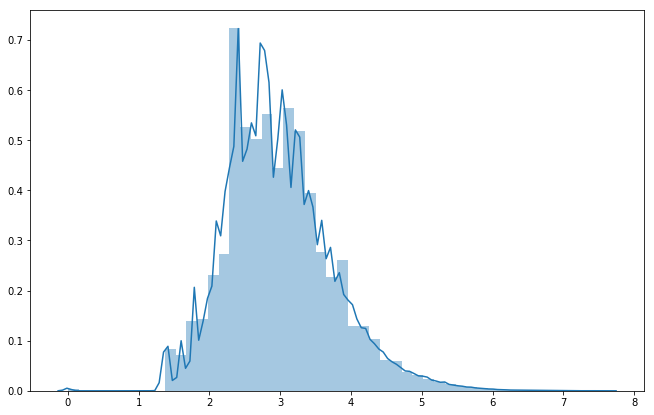

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.distplot(np.log(train_df['price'].values+1))